In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectFromModel

In [2]:
# Load the datasets
stocks_df = pd.read_csv('data/all_stocks_5yr.csv')
sp500_df = pd.read_csv('data/HistoricalPrices.csv')

In [3]:
# Data cleaning
stocks_df.dropna(inplace=True)
sp500_df.dropna(inplace=True)

In [4]:
# Feature Engineering
def calculate_bollinger_bands(df, window=20):
    df['Rolling Mean'] = df['Close'].rolling(window=window).mean()
    df['Upper Band'] = df['Rolling Mean'] + 2 * df['Close'].rolling(window=window).std()
    df['Lower Band'] = df['Rolling Mean'] - 2 * df['Close'].rolling(window=window).std()
    df.dropna(inplace=True)
    return df

def calculate_rsi(df, window=14):
    delta = df['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    df['RSI'] = 100 - (100 / (1 + rs))
    df.dropna(inplace=True)
    return df

def calculate_macd(df, short_window=12, long_window=26):
    df['ShortEMA'] = df['Close'].ewm(span=short_window, min_periods=1).mean()
    df['LongEMA'] = df['Close'].ewm(span=long_window, min_periods=1).mean()
    df['MACD'] = df['ShortEMA'] - df['LongEMA']
    df.dropna(inplace=True)
    return df

In [5]:
# Remove leading whitespaces from column names
sp500_df.columns = sp500_df.columns.str.strip()

In [6]:
# Check the columns of the SP500 dataset (Remove)
print(sp500_df.columns)

Index(['Date', 'Open', 'High', 'Low', 'Close'], dtype='object')


In [7]:
# Apply feature engineering to SP500 data
sp500_df = calculate_bollinger_bands(sp500_df)
sp500_df = calculate_rsi(sp500_df)
sp500_df = calculate_macd(sp500_df)

In [8]:
# Check column names and data types (Remove)
print("Stocks dataset columns:")
print(stocks_df.columns)
print("\nSP500 dataset columns:")
print(sp500_df.columns)

# Convert date formats for consistency
stocks_df['date'] = pd.to_datetime(stocks_df['date'])
sp500_df['Date'] = pd.to_datetime(sp500_df['Date'])

# Check the maximum date in the stocks_df (Remove)
max_date_stocks = stocks_df['date'].max()
print("\nMaximum date in the stocks_df:", max_date_stocks)

# Check the maximum date in the sp500_df (Remove)
max_date_sp500 = sp500_df['Date'].max()
print("Maximum date in the sp500_df dataset:", max_date_sp500)

# Filter merged dataset to ensure overlapping dates
merged_df = pd.merge(stocks_df, sp500_df, left_on='date', right_on='Date', how='inner')

# Check if the merged dataset is empty (Remove)
print("\nMerged dataset:")
print(merged_df.head())

Stocks dataset columns:
Index(['date', 'open', 'high', 'low', 'close', 'volume', 'Name'], dtype='object')

SP500 dataset columns:
Index(['Date', 'Open', 'High', 'Low', 'Close', 'Rolling Mean', 'Upper Band',
       'Lower Band', 'RSI', 'ShortEMA', 'LongEMA', 'MACD'],
      dtype='object')

Maximum date in the stocks_df: 2018-02-07 00:00:00
Maximum date in the sp500_df dataset: 2022-09-14 00:00:00


/tmp/ipykernel_4380/3938756205.py:9: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  sp500_df['Date'] = pd.to_datetime(sp500_df['Date'])



Merged dataset:
        date     open     high      low    close     volume  Name       Date  \
0 2013-02-08  15.0700  15.1200  14.6300  14.7500    8407500   AAL 2013-02-08   
1 2013-02-08  67.7142  68.4014  66.8928  67.8542  158168416  AAPL 2013-02-08   
2 2013-02-08  78.3400  79.7200  78.0100  78.9000    1298137   AAP 2013-02-08   
3 2013-02-08  36.3700  36.4200  35.8250  36.2500   13858795  ABBV 2013-02-08   
4 2013-02-08  46.5200  46.8950  46.4600  46.8900    1232802   ABC 2013-02-08   

      Open     High      Low    Close  Rolling Mean   Upper Band   Lower Band  \
0  1509.39  1518.31  1509.39  1517.93     1520.6165  1551.647461  1489.585539   
1  1509.39  1518.31  1509.39  1517.93     1520.6165  1551.647461  1489.585539   
2  1509.39  1518.31  1509.39  1517.93     1520.6165  1551.647461  1489.585539   
3  1509.39  1518.31  1509.39  1517.93     1520.6165  1551.647461  1489.585539   
4  1509.39  1518.31  1509.39  1517.93     1520.6165  1551.647461  1489.585539   

        RSI   S

In [9]:
# Check the maximum date in the merged dataset
max_date = merged_df['date'].max()
print("Maximum date in the merged dataset:", max_date)

# Check the maximum date in the stocks_df
max_date = stocks_df['date'].max()
print("Maximum date in thestocks_df:", max_date)

# Check the maximum date in the sp500_df
max_date = sp500_df['Date'].max()
print("Maximum date in the sp500_df dataset:", max_date)

Maximum date in the merged dataset: 2018-02-07 00:00:00
Maximum date in thestocks_df: 2018-02-07 00:00:00
Maximum date in the sp500_df dataset: 2022-09-14 00:00:00


In [10]:
# Define features and target
features = ['Upper Band', 'Lower Band', 'RSI', 'MACD']
target = 'Target'

In [11]:
# Create target variable
merged_df['Target'] = np.sign(merged_df['Close'].shift(-1) - merged_df['Close'])

In [12]:
# Binarize the target variable
merged_df['Target'] = np.where(merged_df['Target'] > 0, 1, 0)

In [13]:
# Drop NaN values
merged_df.dropna(inplace=True)

In [14]:
# Splitting the data into train and test sets based on date
train = merged_df[merged_df['date'] < pd.Timestamp('2017-01-01')]
test = merged_df[merged_df['date'] >= pd.Timestamp('2017-01-01')]

In [15]:
print("Train dataset:")
print(train.head())
print("\nTest dataset:")
print(test.head())

Train dataset:
        date     open     high      low    close     volume  Name       Date  \
0 2013-02-08  15.0700  15.1200  14.6300  14.7500    8407500   AAL 2013-02-08   
1 2013-02-08  67.7142  68.4014  66.8928  67.8542  158168416  AAPL 2013-02-08   
2 2013-02-08  78.3400  79.7200  78.0100  78.9000    1298137   AAP 2013-02-08   
3 2013-02-08  36.3700  36.4200  35.8250  36.2500   13858795  ABBV 2013-02-08   
4 2013-02-08  46.5200  46.8950  46.4600  46.8900    1232802   ABC 2013-02-08   

      Open     High      Low    Close  Rolling Mean   Upper Band   Lower Band  \
0  1509.39  1518.31  1509.39  1517.93     1520.6165  1551.647461  1489.585539   
1  1509.39  1518.31  1509.39  1517.93     1520.6165  1551.647461  1489.585539   
2  1509.39  1518.31  1509.39  1517.93     1520.6165  1551.647461  1489.585539   
3  1509.39  1518.31  1509.39  1517.93     1520.6165  1551.647461  1489.585539   
4  1509.39  1518.31  1509.39  1517.93     1520.6165  1551.647461  1489.585539   

        RSI   Sho

In [16]:
# Define the machine learning pipeline
pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler()),
    ('clf', RandomForestClassifier(n_estimators=100))
])

In [17]:
# Function to plot and save cross-validation results
def plot_cv_results(train_accuracies, val_accuracies, train_aucs, val_aucs, file_name):
    plt.figure(figsize=(14, 7))
    plt.subplot(2, 1, 1)
    plt.plot(train_accuracies, marker='o', linestyle='--', label='Train Accuracy')
    plt.plot(val_accuracies, marker='o', linestyle='-', label='Validation Accuracy')
    plt.title('Cross-Validation Accuracy')
    plt.xlabel('Fold')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    plt.subplot(2, 1, 2)
    plt.plot(train_aucs, marker='o', linestyle='--', label='Train AUC')
    plt.plot(val_aucs, marker='o', linestyle='-', label='Validation AUC')
    plt.title('Cross-Validation AUC')
    plt.xlabel('Fold')
    plt.ylabel('AUC')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.savefig(file_name)
    plt.show()
    
# Function to plot the Time Series Split
def plot_time_series_split(tscv, X, file_name):
    fig, ax = plt.subplots()
    for i, (train_index, test_index) in enumerate(tscv.split(X)):
        indices = np.arange(len(X))
        ax.plot(indices[train_index], [i] * len(train_index), 'b.', label='Train' if i == 0 else "")
        ax.plot(indices[test_index], [i] * len(test_index), 'r.', label='Test' if i == 0 else "")
    ax.set_xlabel('Sample index')
    ax.set_ylabel('CV iteration')
    ax.set_title('Time Series Split')
    ax.legend(loc='best')
    plt.grid(True)
    plt.savefig(file_name)
    plt.show()

In [19]:
import pickle
import os

# Define the directory path
directory = 'results/selected-model/'

# Create the directory if it doesn't exist
os.makedirs(directory, exist_ok=True)

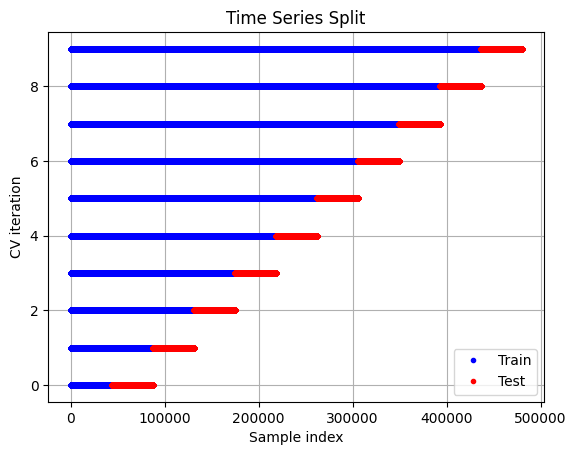

In [20]:
# Train and evaluate the model using Time Series Split cross-validation
tscv = TimeSeriesSplit(n_splits=10)
train_accuracies = []
val_accuracies = []
train_aucs = []
val_aucs = []
cv_iter = 0

# Plot the Time Series Split
plot_time_series_split(tscv, train, 'results/time_series_split.png')

In [21]:
for train_index, val_index in tscv.split(train):
    X_train, X_val = train[features].iloc[train_index], train[features].iloc[val_index]
    y_train, y_val = train[target].iloc[train_index], train[target].iloc[val_index]
    
    pipeline.fit(X_train, y_train)
    train_preds = pipeline.predict(X_train)
    val_preds = pipeline.predict(X_val)
    
    train_accuracy = accuracy_score(y_train, train_preds)
    val_accuracy = accuracy_score(y_val, val_preds)
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)
    
    train_auc = roc_auc_score(y_train, train_preds) 
    val_auc = roc_auc_score(y_val, val_preds)  
    train_aucs.append(train_auc)
    val_aucs.append(val_auc)
    
    print(f"Fold {cv_iter}: Train Accuracy: {train_accuracy}, Validation Accuracy: {val_accuracy}")
    print(f"Fold {cv_iter}: Train AUC: {train_auc}, Validation AUC: {val_auc}")
    
    cv_iter += 1

Fold 0: Train Accuracy: 0.9987851838269002, Validation Accuracy: 0.9987163029525032
Fold 0: Train AUC: 0.5, Validation AUC: 0.5
Fold 1: Train Accuracy: 0.9987507449685967, Validation Accuracy: 0.9989455345681276
Fold 1: Train AUC: 0.5, Validation AUC: 0.5
Fold 2: Train Accuracy: 0.9988156728506372, Validation Accuracy: 0.9987392261140656
Fold 2: Train AUC: 0.5, Validation AUC: 0.5
Fold 3: Train Accuracy: 0.9987965616045845, Validation Accuracy: 0.9988309187603154
Fold 3: Train AUC: 0.5, Validation AUC: 0.5
Fold 4: Train Accuracy: 0.9988034329097211, Validation Accuracy: 0.9990601503759399
Fold 4: Train AUC: 0.5, Validation AUC: 0.5
Fold 5: Train Accuracy: 0.9988462185002369, Validation Accuracy: 0.9989913808912525
Fold 5: Train AUC: 0.5, Validation AUC: 0.5
Fold 6: Train Accuracy: 0.998866955713032, Validation Accuracy: 0.9990372272143774
Fold 6: Train AUC: 0.5, Validation AUC: 0.5
Fold 7: Train Accuracy: 0.9988882394067554, Validation Accuracy: 0.9988996882450027
Fold 7: Train AUC: 0.

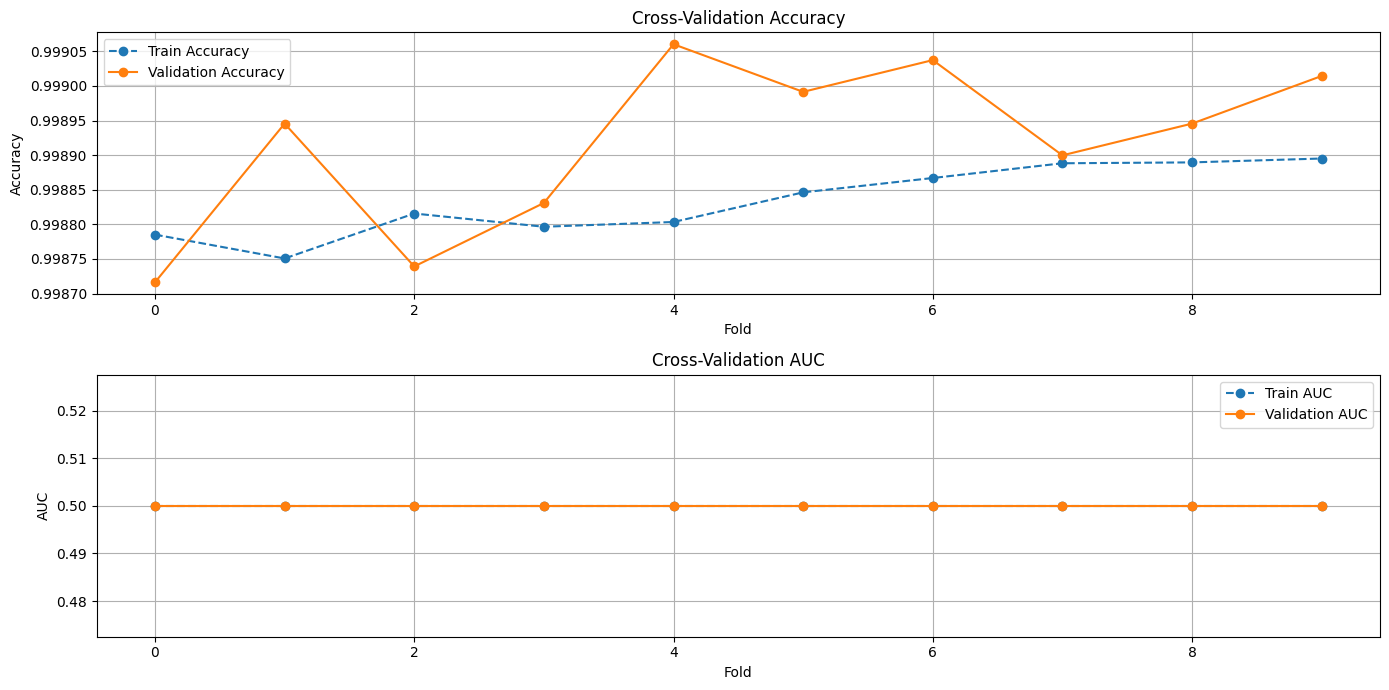

In [23]:
# Plot and save cross-validation results
plot_cv_results(train_accuracies, val_accuracies, train_aucs, val_aucs, 'results/cv_results.png')

In [24]:
# Select the best model and save it
best_model = pipeline
best_model.fit(train[features], train[target])

Pipeline(steps=[('imputer', SimpleImputer()), ('scaler', StandardScaler()),
                ('clf', RandomForestClassifier())])

In [25]:
# Save the selected model
with open(os.path.join(directory, 'selected_model.pkl'), 'wb') as f:
    pickle.dump(best_model, f)

# Save the model's hyperparameters
with open(os.path.join(directory, 'selected_model.txt'), 'w') as f:
    f.write(str(best_model.get_params()))

In [26]:
# Generate the machine learning signal
ml_signal = best_model.predict_proba(test[features])[:, 1]
ml_signal_df = pd.DataFrame(ml_signal, index=test.index, columns=['ML Signal'])
ml_signal_df.to_csv('results/selected-model/ml_signal.csv')

In [27]:
# Convert machine learning signal into financial strategy
def generate_strategy(signal, prices):
    strategy = signal * prices['Target'].shift(-1)
    return strategy

In [28]:
# Backtest the strategy
train_strategy = generate_strategy(ml_signal_df['ML Signal'], train)
test_strategy = generate_strategy(ml_signal_df['ML Signal'], test)

In [29]:
# Calculate PnL
train_pnl = train_strategy.cumsum()
test_pnl = test_strategy.cumsum()

In [30]:
# Calculate Max Drawdown
train_max_drawdown = train_pnl - train_pnl.expanding().max()
test_max_drawdown = test_pnl - test_pnl.expanding().max()

In [31]:
# Define the directory path
directory = 'results/strategy/'

# Create the directory if it doesn't exist
os.makedirs(directory, exist_ok=True)

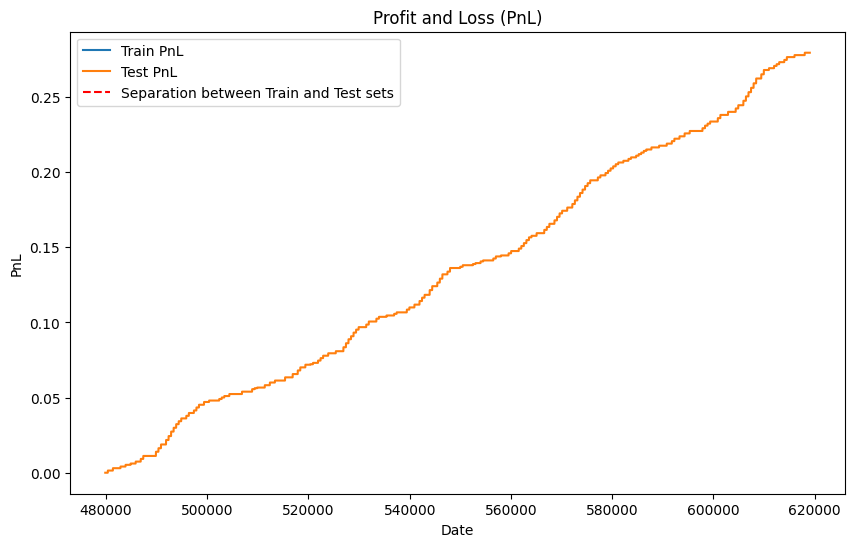

In [32]:
# Plot PnL
plt.figure(figsize=(10, 6))
plt.plot(train_pnl.index, train_pnl.values, label='Train PnL')
plt.plot(test_pnl.index, test_pnl.values, label='Test PnL')
plt.plot([train.index[-1], train.index[-1]], [min(train_pnl.min(), test_pnl.min()), max(train_pnl.max(), test_pnl.max())], linestyle='--', color='red', label='Separation between Train and Test sets')
plt.xlabel('Date')
plt.ylabel('PnL')
plt.title('Profit and Loss (PnL)')
plt.legend()
plt.savefig('results/strategy/strategy.png')

In [33]:
# Calculate other metrics
train_metrics = {
    'PnL': train_pnl.iloc[-1],
    'Max Drawdown': train_max_drawdown.min(),
}

test_metrics = {
    'PnL': test_pnl.iloc[-1],
    'Max Drawdown': test_max_drawdown.min(),
}

In [34]:
# Save strategy metrics
strategy_metrics = pd.DataFrame({'Train': train_metrics, 'Test': test_metrics})
strategy_metrics.to_csv('results/strategy/results.csv')

In [35]:
# Generate report
report = """
## Financial Strategy Report

### Features Used
- Bollinger Bands (Upper and Lower)
- Relative Strength Index (RSI)
- Moving Average Convergence Divergence (MACD)

### Pipeline Used
- Imputer: SimpleImputer(strategy='mean')
- Scaler: StandardScaler()
- Model: RandomForestClassifier(n_estimators=100)

### Cross-Validation Used
- Time Series Split with 10 folds
- Length of Train Sets: Varies with each fold
- Length of Validation Sets: Varies with each fold

### Strategy Chosen
- Description: Long/Short strategy based on ML signal
- PnL Plot: [Strategy Plot](results/strategy/strategy.png)

#### Strategy Metrics
"""
report += strategy_metrics.to_markdown()

with open('results/strategy/report.md', 'w') as f:
    f.write(report)